# UCI - Human Action Recognition - CNN

### `import` statements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf  # Import TensorFlow
from tensorflow.keras.models import Sequential
from time import perf_counter as tpc
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report as cr

### Set random generator seed

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# Data directory
DATADIR = '/Users/alesandrawiecheckivergara/Desktop/PR/ICP/human+activity+recognition+using+smartphones/UCI HAR Dataset'

# Signals to load
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

activity_map = {
    0: "Walking",
    1: "Walking Upstairs",
    2: "Walking Downstairs",
    3: "Sitting",
    4: "Standing",
    5: "Laying"
}

### Utility Functions to load and process dataset

In [4]:
# Utility function to read CSV files
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Function to load signal data
def load_signals(subset):
    signals_data = []
    for signal in SIGNALS:
        filename = f'{DATADIR}/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(_read_csv(filename).to_numpy())
    return np.transpose(signals_data, (1, 2, 0))  # Shape: (samples, timesteps, signals)

# Function to load labels
def load_y(subset):
    filename = f'{DATADIR}/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    return pd.get_dummies(y).to_numpy()  # One-hot encoded labels

# Function to load the entire dataset
def load_data():
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')
    return X_train, X_test, y_train, y_test

### Load the dataset

In [5]:
# Load the dataset
X_train, X_test, Y_train, Y_test = load_data()

# Print dataset shapes
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

# Convert one-hot labels to class indices
Y_train = np.argmax(Y_train, axis=1)
Y_test = np.argmax(Y_test, axis=1)

# Verify the shapes after conversion
print(f"Y_train shape after conversion: {Y_train.shape}")
print(f"Y_test shape after conversion: {Y_test.shape}")

X_train shape: (7352, 128, 9), Y_train shape: (7352, 6)
X_test shape: (2947, 128, 9), Y_test shape: (2947, 6)
Y_train shape after conversion: (7352,)
Y_test shape after conversion: (2947,)


### Visualize a single sample

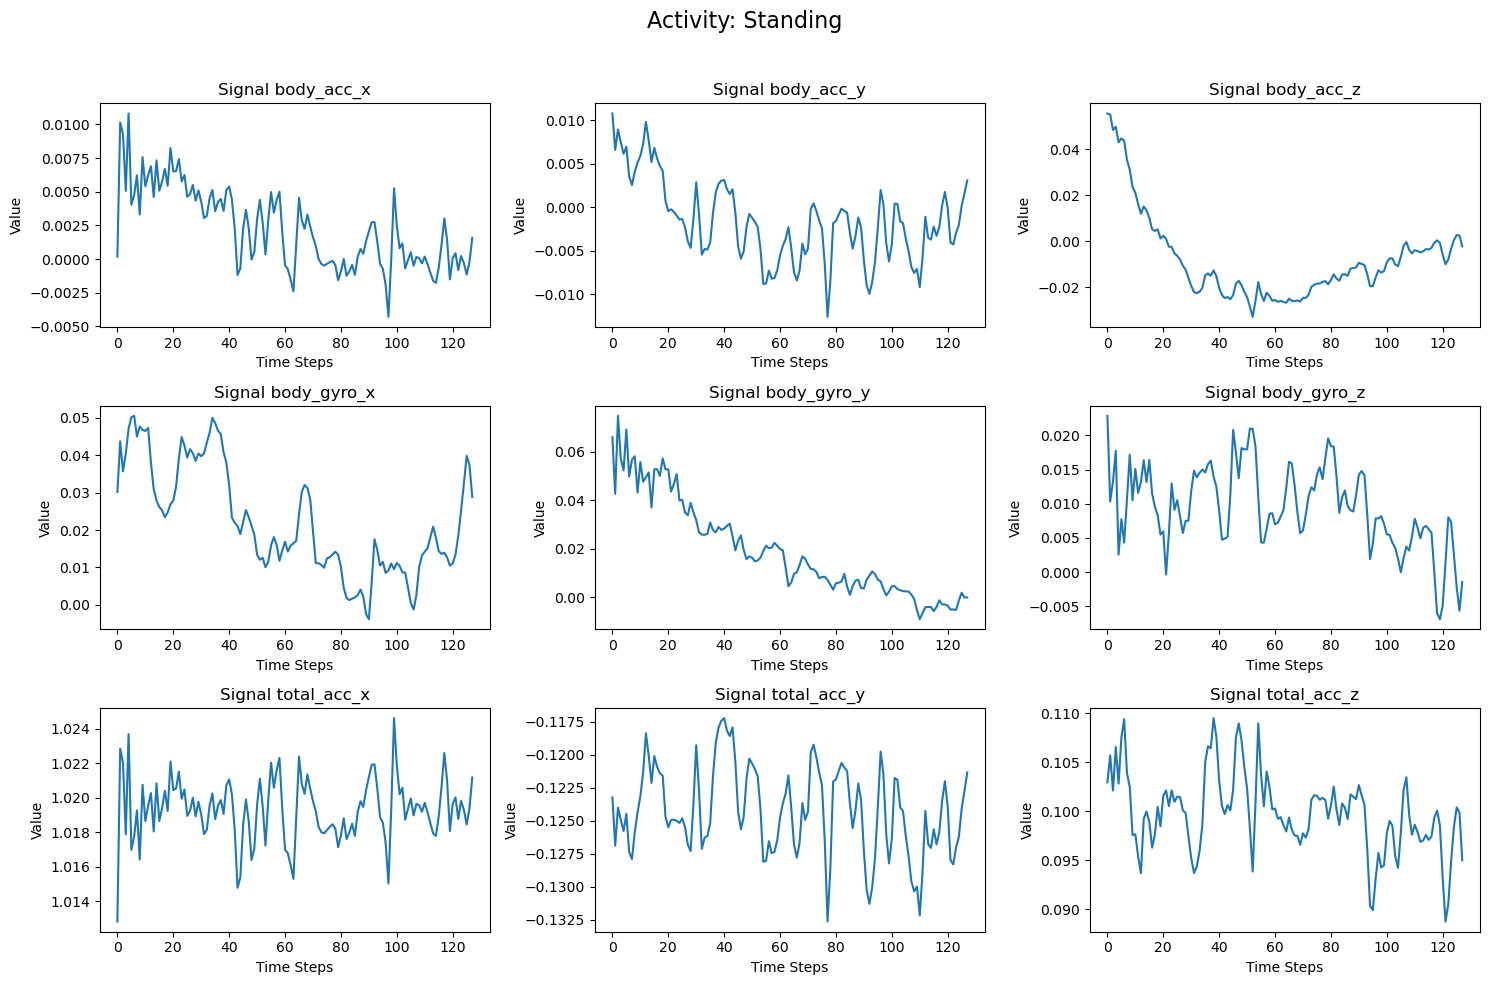

In [6]:
# Visualize a single sample
def plot_single_sample(sample_idx, X_data, y_data):
    sample = X_data[sample_idx]
    activity = activity_map[y_data[sample_idx]]
    fig, axs = plt.subplots(3, 3, figsize=(15, 10))
    axs = axs.ravel()
    for i in range(9):  # 9 signals
        axs[i].plot(sample[:, i])
        axs[i].set_title(f"Signal {SIGNALS[i]}")
        axs[i].set_xlabel("Time Steps")
        axs[i].set_ylabel("Value")
    plt.suptitle(f"Activity: {activity}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_single_sample(sample_idx=0, X_data=X_train, y_data=Y_train)


### Reshape the data for CNN

In [7]:
X_train = X_train.reshape(X_train.shape[0], -1, X_train.shape[-1])  # Flatten timesteps
X_test = X_test.reshape(X_test.shape[0], -1, X_test.shape[-1])

print(X_train.shape)  # This will give you the shape of the training data

(7352, 128, 9)


## Define the CNN model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [9]:
# Define the CNN model
epochs = 50
batch_size = 64
dropout_rate = 0.2
learning_rate = 0.001
patience = 20
input_shape = X_train.shape[1:]  # Dynamically get the timesteps and features
num_classes = 6  # Number of classes


def CNN(input_shape, num_classes, dropout_rate=dropout_rate):
    model = Sequential()

    # First Conv1D layer
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))

    # Second Conv1D layer
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))

    # Third Conv1D layer
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(MaxPooling1D(pool_size=2))

    # Flatten and Fully Connected layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  # Hidden layer
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer

    return model

# Build the CNN model
model = CNN(input_shape, num_classes)
# Define the optimizer with the custom learning rate
optimizer = Adam(learning_rate=learning_rate)


/Users/alesandrawiecheckivergara/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Model Summary

In [10]:
# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 128)       │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 63, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 61, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 28, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 896)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,166 (610.02 KB)

 Trainable params: 156,166 (610.02 KB)

 Non-trainable params: 0 (0.00 B)

### Trainning Model

In [11]:
tic = tpc() # Start time...

# Train the model
history = model.fit(
    X_train, Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, Y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)]
)

toc = tpc() # End time...

!say "CNN model fitting completed"

myTime = toc - tic
myTimeMins = myTime // 60
myTimeSecs = myTime % 60
timingStr = "CNN Model took {Mins:.0f} minutes and {Secs:=.2f} seconds to fit!".format(Mins=myTimeMins,Secs=myTimeSecs)
print(timingStr)
!say {timingStr}


Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5721 - loss: 1.0179 - val_accuracy: 0.8273 - val_loss: 0.4678
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9038 - loss: 0.2417 - val_accuracy: 0.8968 - val_loss: 0.2703
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9478 - loss: 0.1353 - val_accuracy: 0.9101 - val_loss: 0.2722
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9528 - loss: 0.1210 - val_accuracy: 0.9101 - val_loss: 0.2831
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9464 - loss: 0.1177 - val_accuracy: 0.9135 - val_loss: 0.2708
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9528 - loss: 0.1058 - val_accuracy: 0.9070 - val_loss: 0.2722
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9540 - loss: 0.1065 - val_accuracy: 0.9114 - val_loss: 0.3039
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9568 - loss: 0.1022 - val_accur

### Plot training history

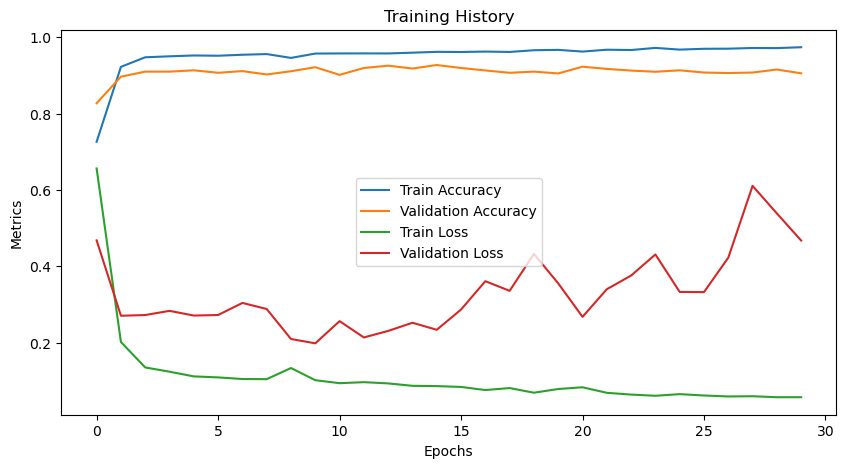

In [12]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.title('Training History')
    plt.show()
    
plot_training_history(history)

### Evaluate the model

In [13]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, Y_test, batch_size=batch_size)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8718 - loss: 0.2547
Test Accuracy: 92.16%


### Confusion Matrix

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


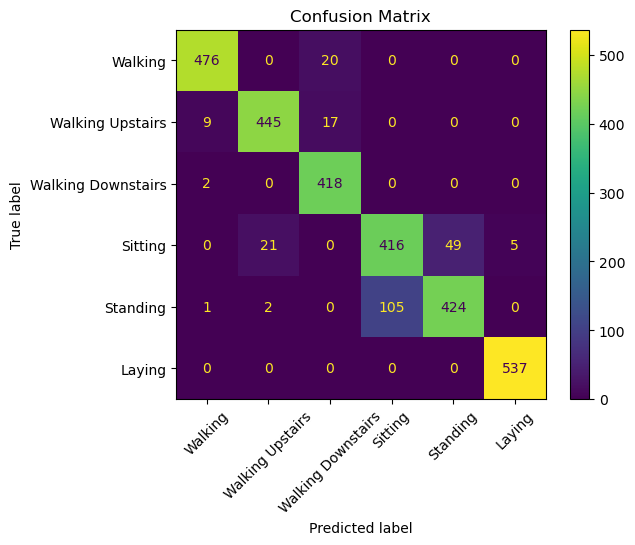

In [14]:
# Confusion Matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
conf_matrix = cm(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(activity_map.values()))
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

### Classification Report

In [16]:
print(cr(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       496
           1       0.95      0.94      0.95       471
           2       0.92      1.00      0.96       420
           3       0.80      0.85      0.82       491
           4       0.90      0.80      0.84       532
           5       0.99      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947

